In [2]:
import os
import pandas as pd
from PIL import Image
from torchvision import transforms
from transformers import AutoTokenizer
import transformers
import torch
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset

In [3]:


image_folder = '/kaggle/input/isic-2020-jpg-256x256-resized/train-image/image'
csv_file = '/kaggle/input/meta-data/ISIC_2020_Training_GroundTruth.csv'

metadata = pd.read_csv(csv_file)



## This is for loading

In [3]:
import torch.nn as nn
from torchvision import models

resnet = models.resnet50(pretrained=True)
feature_extractor = nn.Sequential(*list(resnet.children())[:-1], nn.Flatten(), nn.Linear(resnet.fc.in_features, 1))


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 171MB/s] 


In [4]:

feature_extractor.load_state_dict(torch.load('/kaggle/input/feature-extractor-weights/feature_extractor.pth'))


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_extractor.to(device)

# Set the model to evaluation mode i
feature_extractor.eval()


/tmp/ipykernel_30/2094698977.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  feature_extractor.load_state_dict(torch.load('/kaggle/input/feature-extractor-weights/featur

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


## Below is for training

In [7]:
import torch
import torch.nn as nn
from torchvision import models

# Load pre-trained ResNet model
resnet = models.resnet50(pretrained=True)
# Remove the final classification layer to extract features
feature_extractor = nn.Sequential(*list(resnet.children())[:-1])

# Define image transformations (resize, normalization, etc.)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])




In [8]:
# Define a function to convert metadata into text format
def metadata_to_text(row):
    text = f"Patient is a {row['age_approx']}-year-old {row['sex']} with a lesion on the {row['anatom_site_general_challenge']}."
    return text


In [80]:
class CustomDataset(Dataset):
    def __init__(self, image_folder, csv_file, transform=None):
        self.image_folder = image_folder
        self.metadata = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        img_name = f"{self.image_folder}/{self.metadata.iloc[idx]['image_name']}.jpg"
        image = Image.open(img_name).convert('RGB')
        label = self.metadata.iloc[idx]['target']
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Create an instance of the dataset
dataset = CustomDataset(image_folder=image_folder, csv_file=csv_file, transform=transform)

In [83]:
from torch.utils.data import DataLoader
batch_size = 64  # Try increasing from 32 to 64 or even higher, depending on your GPU
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [12]:
import torch.optim as optim


# Add a classification layer to the feature extractor
num_classes = 1  # Binary classification
feature_extractor = nn.Sequential(*list(resnet.children())[:-1], nn.Flatten(), nn.Linear(resnet.fc.in_features, num_classes))

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_extractor.to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(feature_extractor.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    feature_extractor.train()
    running_loss = 0.0
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device).float()

        optimizer.zero_grad()
        outputs = feature_extractor(images)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        # Print batch-wise progress
        if (batch_idx + 1) % 10 == 0:  
            print(f"Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    scheduler.step()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Average Loss: {running_loss / len(train_loader):.4f}")

Epoch [1/5], Batch [10/518], Loss: 0.0041
Epoch [1/5], Batch [20/518], Loss: 0.0154
Epoch [1/5], Batch [30/518], Loss: 0.0849
Epoch [1/5], Batch [40/518], Loss: 0.2344
Epoch [1/5], Batch [50/518], Loss: 0.1283
Epoch [1/5], Batch [60/518], Loss: 0.0715
Epoch [1/5], Batch [70/518], Loss: 0.1434
Epoch [1/5], Batch [80/518], Loss: 0.1757
Epoch [1/5], Batch [90/518], Loss: 0.1539
Epoch [1/5], Batch [100/518], Loss: 0.0795
Epoch [1/5], Batch [110/518], Loss: 0.1367
Epoch [1/5], Batch [120/518], Loss: 0.0229
Epoch [1/5], Batch [130/518], Loss: 0.1033
Epoch [1/5], Batch [140/518], Loss: 0.0991
Epoch [1/5], Batch [150/518], Loss: 0.0734
Epoch [1/5], Batch [160/518], Loss: 0.0804
Epoch [1/5], Batch [170/518], Loss: 0.0740
Epoch [1/5], Batch [180/518], Loss: 0.0089
Epoch [1/5], Batch [190/518], Loss: 0.0613
Epoch [1/5], Batch [200/518], Loss: 0.1200
Epoch [1/5], Batch [210/518], Loss: 0.0663
Epoch [1/5], Batch [220/518], Loss: 0.0156
Epoch [1/5], Batch [230/518], Loss: 0.0671
Epoch [1/5], Batch [

In [29]:
torch.save(feature_extractor.state_dict(), 'feature_extractor.pth')

## Using after loading/training

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

feature_extractor = nn.Sequential(*list(feature_extractor.children())[:-1])  # Exclude the last layer
feature_extractor.to(device) 
feature_extractor.eval()

def extract_image_features(image_path):
    img = Image.open(image_path).convert('RGB')
    img = transform(img).unsqueeze(0).to(device)  # Add batch dimension and move to device
    with torch.no_grad():
        features = feature_extractor(img)  # Get features without flattening
        features = features.view(features.size(0), -1)  # Flatten all dimensions except batch
    return features


def get_feature_vector(image_path):
    features = extract_image_features(image_path).to(device)
    return features

# Example use
image_path = "/kaggle/input/isic-2020-jpg-256x256-resized/train-image/image/ISIC_0015719.jpg" # Update with actual image path
feature_vector = get_feature_vector(image_path)
print(feature_vector.shape)  # Should print the shape of the feature vector



torch.Size([1, 2048])


In [7]:


# Function to get features for all images in the directory
def get_all_image_features(image_dir):
    image_features = []
    image_paths = [os.path.join(image_dir, filename) for filename in os.listdir(image_dir) if filename.endswith(('.jpg', '.png', '.jpeg'))]
    
    for image_path in image_paths:
        feature_vector = extract_image_features(image_path)
        image_features.append(feature_vector)
        
    return torch.cat(image_features)  


image_directory = "/kaggle/input/isic-2020-jpg-256x256-resized/train-image/image"
all_image_features = get_all_image_features(image_directory)
print(all_image_features.shape)  #

torch.Size([33126, 2048])


In [8]:
metadata = pd.read_csv(csv_file)


print(metadata.head())


#  a function to convert metadata into text format
def metadata_to_text(row):
    text = f"Patient is a {row['age_approx']}-year-old {row['sex']} with a lesion on the {row['anatom_site_general_challenge']}."
    return text

# Apply the function to create a new 'text' column in the metadata DataFrame
metadata['text'] = metadata.apply(metadata_to_text, axis=1)


print(metadata[['age_approx', 'sex', 'anatom_site_general_challenge', 'text']].head())

     image_name  patient_id     sex  age_approx anatom_site_general_challenge  \
0  ISIC_2637011  IP_7279968    male        45.0                     head/neck   
1  ISIC_0015719  IP_3075186  female        45.0               upper extremity   
2  ISIC_0052212  IP_2842074  female        50.0               lower extremity   
3  ISIC_0068279  IP_6890425  female        45.0                     head/neck   
4  ISIC_0074268  IP_8723313  female        55.0               upper extremity   

  diagnosis benign_malignant  target  
0   unknown           benign       0  
1   unknown           benign       0  
2     nevus           benign       0  
3   unknown           benign       0  
4   unknown           benign       0  
     image_name  patient_id     sex  age_approx anatom_site_general_challenge  \
0  ISIC_2637011  IP_7279968    male        45.0                     head/neck   
1  ISIC_0015719  IP_3075186  female        45.0               upper extremity   
2  ISIC_0052212  IP_2842074  female 

In [9]:
import nltk
from nltk.tokenize import word_tokenize

# Tokenization function using NLTK
def tokenize_text(text):
    return word_tokenize(text.lower())  # Lowercasing for consistency

# Tokenize the text column
metadata['tokens'] = metadata['text'].apply(tokenize_text)

# Display the updated DataFrame with the new 'text' and 'tokens' columns
print(metadata[['age_approx', 'sex', 'anatom_site_general_challenge', 'text', 'tokens']].head(1))

   age_approx   sex anatom_site_general_challenge  \
0        45.0  male                     head/neck   

                                                text  \
0  Patient is a 45.0-year-old male with a lesion ...   

                                              tokens  
0  [patient, is, a, 45.0-year-old, male, with, a,...  


In [10]:
print(metadata[['text', 'tokens']].head())

                                                text  \
0  Patient is a 45.0-year-old male with a lesion ...   
1  Patient is a 45.0-year-old female with a lesio...   
2  Patient is a 50.0-year-old female with a lesio...   
3  Patient is a 45.0-year-old female with a lesio...   
4  Patient is a 55.0-year-old female with a lesio...   

                                              tokens  
0  [patient, is, a, 45.0-year-old, male, with, a,...  
1  [patient, is, a, 45.0-year-old, female, with, ...  
2  [patient, is, a, 50.0-year-old, female, with, ...  
3  [patient, is, a, 45.0-year-old, female, with, ...  
4  [patient, is, a, 55.0-year-old, female, with, ...  


In [11]:
from collections import Counter
def build_vocab(tokens):
    counter = Counter(token for sublist in tokens for token in sublist)
    vocab = {token: idx + 1 for idx, (token, _) in enumerate(counter.most_common())}  # Start indices from 1
    vocab['<pad>'] = 0  # Add padding token
    return vocab

# Build vocabulary from tokenized data
vocab = build_vocab(metadata['tokens'].tolist())

def numericalize(tokens, vocab):
    return [vocab[token] for token in tokens]

# Apply numericalization
metadata['numerical_tokens'] = metadata['tokens'].apply(lambda x: numericalize(x, vocab))

In [12]:
print(len(metadata['numerical_tokens']))
print(len(metadata['target']))

33126
33126


In [96]:
for i in range(5):
    print(len(metadata['numerical_tokens'].iloc[i]), metadata['numerical_tokens'].iloc[i])


12 [2, 3, 1, 15, 9, 4, 1, 5, 6, 7, 24, 8]
13 [2, 3, 1, 15, 11, 4, 1, 5, 6, 7, 14, 12, 8]
13 [2, 3, 1, 16, 11, 4, 1, 5, 6, 7, 13, 12, 8]
12 [2, 3, 1, 15, 11, 4, 1, 5, 6, 7, 24, 8]
13 [2, 3, 1, 17, 11, 4, 1, 5, 6, 7, 14, 12, 8]


In [14]:
from torch.utils.data import Dataset, DataLoader,random_split

# Step 1: Padding Function
def pad_sequences(sequences, padding_value=0):
    # Convert tensors to lists for padding
    sequences = [seq.tolist() for seq in sequences]
    max_len = max(len(seq) for seq in sequences)
    padded_sequences = [seq + [padding_value] * (max_len - len(seq)) for seq in sequences]
    return padded_sequences

# Step 2: Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, metadata, image_features):
        self.metadata = metadata
        self.image_features = image_features

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        text = self.metadata['numerical_tokens'].iloc[idx]
        sentence = self.metadata['text'].iloc[idx]
        label = self.metadata['target'].iloc[idx]
        image_feature = self.image_features[idx]  # Get the corresponding image feature
        return torch.tensor(text, dtype=torch.long), torch.tensor(label, dtype=torch.float), torch.tensor(image_feature, dtype=torch.float),sentence

# Create the dataset with both metadata and image features
dataset = CustomDataset(metadata, all_image_features)

# Step 3: Custom Collate Function
def collate_fn(batch):
    texts,  labels, image_features,sentences = zip(*batch)  # Unzip the batch
    padded_texts = pad_sequences(texts)
    return (torch.tensor(padded_texts, dtype=torch.long), 
            torch.stack(labels), 
            torch.stack(image_features),
            list(sentences))  # Stack image features


# Step 4: Create Dataset and DataLoader
dataset_Combined_model = CustomDataset(metadata,all_image_features)
train_size = int(0.85 * len(dataset))
test_size = len(dataset) - train_size

# Split the dataset into training and testing sets
train_dataset, test_dataset = random_split(dataset_Combined_model, [train_size, test_size])

# Create data loaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

# Example of checking the sizes of the datasets
print(f"Training samples: {len(train_dataset)}")
print(f"Testing samples: {len(test_dataset)}")

Training samples: 28157
Testing samples: 4969


In [5]:
import torch
import torch.nn as nn
from torchvision import models

class CombinedModel(nn.Module):
    def __init__(self, image_feature_dim, text_vocab_size, emb_dim, hidden_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(text_vocab_size, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hidden_dim, batch_first=True)  # Ensure batch_first=True
        self.fc_image = nn.Linear(image_feature_dim, hidden_dim)
        self.fc_output = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, image_features, text):
        embedded = self.embedding(text)
        rnn_output, (hidden, _) = self.rnn(embedded)
        text_representation = hidden[-1]  # Last hidden state

        image_representation = self.fc_image(image_features)

        # Check dimensions before concatenation
        # print(f"Text representation shape: {text_representation.shape}")
        # print(f"Image representation shape: {image_representation.shape}")

        combined = torch.cat((text_representation, image_representation), dim=1)  # Combine features
        output = self.fc_output(combined)
        return output

In [17]:
model = CombinedModel(image_feature_dim=2048, text_vocab_size=len(vocab), emb_dim=100, hidden_dim=128, output_dim=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

num_epochs = 10
model_save_path = 'combined_model_weights.pth'
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (text, label, image_features,sentence) in enumerate(train_loader):  # Unpack image features
        # Move data to device
        text = text.to(device)
        label = label.to(device)
        image_features = image_features.to(device)  # Move image features to device

        # Forward pass
        optimizer.zero_grad()
        output = model(image_features, text)
        loss = criterion(output.squeeze(), label)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        # Print batch progress
        if (batch_idx + 1) % 10 == 0:  # Print every 10 batches
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # Optionally print loss at the end of each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}] completed, Last Loss: {loss.item():.4f}")

torch.save(model.state_dict(), model_save_path)
print(f"Model weights saved to {model_save_path}")

/tmp/ipykernel_30/1750558252.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(text, dtype=torch.long), torch.tensor(label, dtype=torch.float), torch.tensor(image_feature, dtype=torch.float),sentence


Epoch [1/10], Batch [10/440], Loss: 0.1311
Epoch [1/10], Batch [20/440], Loss: 0.0736
Epoch [1/10], Batch [30/440], Loss: 0.2176
Epoch [1/10], Batch [40/440], Loss: 0.0754
Epoch [1/10], Batch [50/440], Loss: 0.1594
Epoch [1/10], Batch [60/440], Loss: 0.0205
Epoch [1/10], Batch [70/440], Loss: 0.3192
Epoch [1/10], Batch [80/440], Loss: 0.0809
Epoch [1/10], Batch [90/440], Loss: 0.0346
Epoch [1/10], Batch [100/440], Loss: 0.0116
Epoch [1/10], Batch [110/440], Loss: 0.0147
Epoch [1/10], Batch [120/440], Loss: 0.0869
Epoch [1/10], Batch [130/440], Loss: 0.0153
Epoch [1/10], Batch [140/440], Loss: 0.1479
Epoch [1/10], Batch [150/440], Loss: 0.0121
Epoch [1/10], Batch [160/440], Loss: 0.2534
Epoch [1/10], Batch [170/440], Loss: 0.0815
Epoch [1/10], Batch [180/440], Loss: 0.1614
Epoch [1/10], Batch [190/440], Loss: 0.0235
Epoch [1/10], Batch [200/440], Loss: 0.0194
Epoch [1/10], Batch [210/440], Loss: 0.0139
Epoch [1/10], Batch [220/440], Loss: 0.0847
Epoch [1/10], Batch [230/440], Loss: 0.02

In [62]:
second_row = metadata[['image_name', 'text', 'numerical_tokens','target']].iloc[1]

# Extract image name and tokens
image_name = second_row['image_name']
tokens = second_row['numerical_tokens']
target = second_row['target']

print(f"Image Name: {image_name}")
print(f"Tokens: {tokens}")
print(f"Target: {target}")

Image Name: ISIC_0015719
Tokens: [2, 3, 1, 15, 11, 4, 1, 5, 6, 7, 14, 12, 8]
Target: 0


In [6]:
# Reinitialize the model
model_save_path = '/kaggle/input/combined-model/combined_model_weights.pth'
model = CombinedModel(image_feature_dim=2048, text_vocab_size=len(vocab), emb_dim=100, hidden_dim=128, output_dim=1).to(device)

# Load the model weights
model.load_state_dict(torch.load(model_save_path))
model.eval()  # Set the model to evaluation mode

print("Model weights loaded successfully.")


NameError: name 'vocab' is not defined

In [139]:
import torch
import numpy as np

# Set the model to evaluation mode
model.eval()

# Prepare a list to store predictions and their corresponding labels
predictions = []
labels_list = []
sentences_list = []


# Step 1: Perform inference using the test_loader
with torch.no_grad():  # Disable gradient calculation for inference
    for batch_idx, (text, label, image_features,sentence) in enumerate(test_loader):  # Include image features
        # Move data to device
        text = text.to(device)
        label = label.to(device)
        image_features = image_features.to(device)  # Move image features to device

        # Forward pass
        output = model(image_features, text)  # Ensure all inputs are on the same device
        prediction = torch.sigmoid(output)  # Apply sigmoid to get probabilities

        # Store predictions and labels
        predictions.append(prediction.cpu().numpy())  # Move to CPU for easier handling
        labels_list.append(label.cpu().numpy())
        sentences_list.extend([s.item() for s in sentences])

# Step 2: Process and concatenate results
predictions = np.concatenate(predictions)  # Flatten the list of predictions
labels_list = np.concatenate(labels_list)  # Flatten the list of labels

# Convert probabilities to binary classes (0 or 1)
predicted_classes = (predictions >= 0.5).astype(int)  # Assuming a threshold of 0.5

# Print results for the first few samples
for idx in range(min(10, len(predicted_classes))):  # Print first 10 results
    print(f"Sample {idx + 1}: Predicted Probability: {predictions[idx][0]:.4f}, "
          f"Predicted Class: {predicted_classes[idx][0]}, Actual Class: {labels_list[idx]}")

# Calculate accuracy
accuracy = np.mean(predicted_classes == labels_list[:, None])  # Compare with actual labels
total_accuracy = accuracy * 100  # Convert to percentage

# Print total accuracy
print(f"Total Accuracy: {total_accuracy:.2f}%")


/tmp/ipykernel_30/1301338127.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(text, dtype=torch.long), torch.tensor(label, dtype=torch.float), torch.tensor(image_feature, dtype=torch.float),sentence


Sample 1: Predicted Probability: 0.0141, Predicted Class: 0, Actual Class: 0.0
Sample 2: Predicted Probability: 0.0060, Predicted Class: 0, Actual Class: 0.0
Sample 3: Predicted Probability: 0.0059, Predicted Class: 0, Actual Class: 0.0
Sample 4: Predicted Probability: 0.0076, Predicted Class: 0, Actual Class: 0.0
Sample 5: Predicted Probability: 0.0090, Predicted Class: 0, Actual Class: 0.0
Sample 6: Predicted Probability: 0.0147, Predicted Class: 0, Actual Class: 0.0
Sample 7: Predicted Probability: 0.0093, Predicted Class: 0, Actual Class: 0.0
Sample 8: Predicted Probability: 0.0501, Predicted Class: 0, Actual Class: 0.0
Sample 9: Predicted Probability: 0.0083, Predicted Class: 0, Actual Class: 0.0
Sample 10: Predicted Probability: 0.0319, Predicted Class: 0, Actual Class: 0.0
Total Accuracy: 98.11%


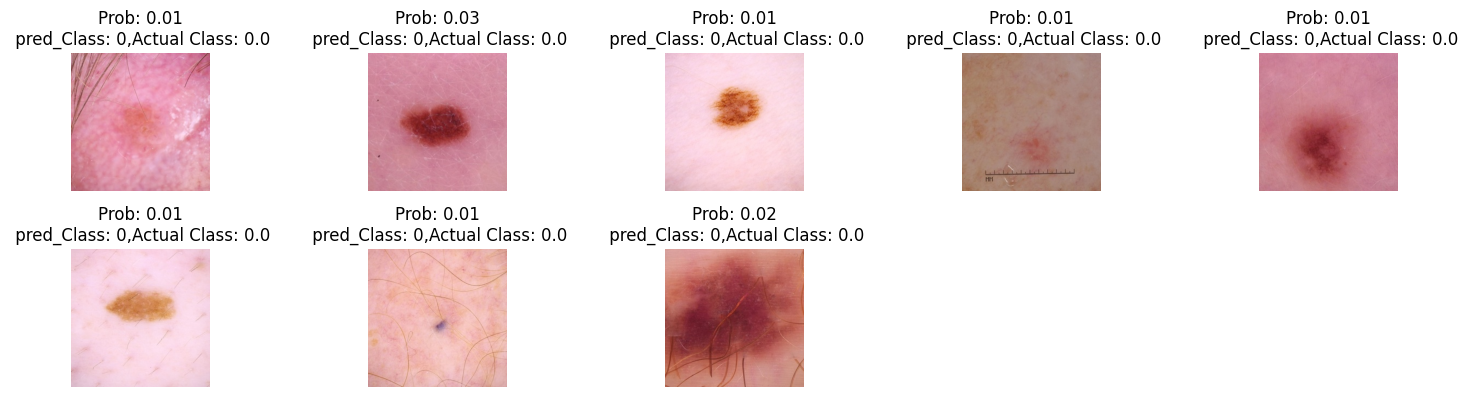

In [78]:
import matplotlib.pyplot as plt
import os
from PIL import Image

# Function to load an image from a given path
def load_image(image_name, image_folder):
    image_path = os.path.join(image_folder, image_name + '.jpg')
    return Image.open(image_path)

# Set your image folder path
image_folder = '/kaggle/input/isic-2020-jpg-256x256-resized/train-image/image'  # Update this to your actual image folder path

# Define which indices you want to plot
# Example: To plot indices 0, 2, 5, and 10
selected_indices = [0, 2, 5, 10, 12, 15, 18, 1009]  # Update this list as needed

# Create a figure for the plot
plt.figure(figsize=(15, 8))

# Loop through the selected indices
for idx in selected_indices:
    # Load the corresponding image
    image_name = metadata['image_name'].iloc[idx]  # Assuming 'image_name' is the column for image file names
    image = load_image(image_name, image_folder)

    # Plot the image
    plt.subplot(4, 5, selected_indices.index(idx) + 1)  # Arrange in 4 rows and 5 columns
    plt.imshow(image)
    plt.axis('off')  # Turn off axis
    plt.title(f"Prob: {predictions[idx][0]:.2f}\n pred_Class: {predicted_classes[idx][0]},Actual Class: {labels_list[idx]}")

plt.tight_layout()
plt.show()


# New Data Inference

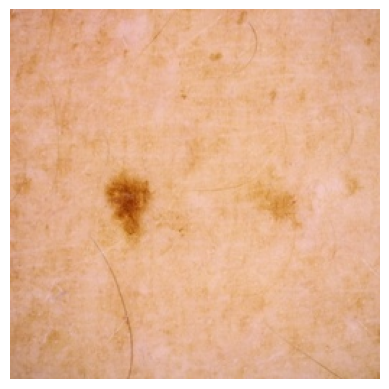

/tmp/ipykernel_30/1649523163.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_feature_tensor = torch.tensor(feature_vector, dtype=torch.float)


In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming get_feature_vector is defined elsewhere
image_path = "/kaggle/input/isic-2020-jpg-256x256-resized/train-image/image/ISIC_0015719.jpg"
image = Image.open(image_path)

# Show the image
plt.imshow(image)
plt.axis('off')  # Optional: turn off the axis
plt.show()
feature_vector = get_feature_vector(image_path)

# Define the row as a DataFrame
row_data = {
    "image_name": ["ISIC_2637011"],
    "patient_id": ["IP_7279968"],
    "sex": ["male"],
    "age_approx": [45.0],
    "anatom_site_general_challenge": ["head/neck"],
    "target": [0]
}

# Create a DataFrame from the row data
row_df = pd.DataFrame(row_data)

# Function to create text from metadata
def metadata_to_text(row):
    text = f"Patient is a {row['age_approx']}-year-old {row['sex']} with a lesion on the {row['anatom_site_general_challenge']}."
    return text

# Apply the function to create a new 'text' column in the metadata DataFrame
row_df['text'] = row_df.apply(metadata_to_text, axis=1)

# Extract the single text for processing
single_text = row_df['text'].iloc[0]

# Tokenization
tokens = tokenize_text(single_text)

# Build vocabulary (assuming you have the full metadata DataFrame defined somewhere)
vocab = build_vocab(metadata['tokens'].tolist())

# Numericalization
numerical_tokens = numericalize(tokens, vocab)

# Display results
# print("Original Text:", single_text)
# print("Tokens:", tokens)
# print("Numerical Tokens:", numerical_tokens)

text = numerical_tokens
text_tensor = torch.tensor(text, dtype=torch.long).unsqueeze(0)
image_feature_tensor = torch.tensor(feature_vector, dtype=torch.float)
text_tensor = text_tensor.to(device)
image_feature_tensor = image_feature_tensor.to(device)

In [42]:

model.eval()  
with torch.no_grad():  
    print(f"Text tensor shape: {text_tensor.shape}")  
    print(f"Image feature tensor shape: {image_feature_tensor.shape}")  

    output = model(image_feature_tensor, text_tensor)  
    prediction = torch.sigmoid(output)  

predicted_class = (prediction >= 0.5).int()  


if predicted_class.item() == 0:
    print("Predicted Probability: {:.4f}, Predicted Class: 0 \n (You are Normal, No Issues)".format(prediction.item()))
else:
    print("Predicted Probability: {:.4f}, Predicted Class: 1 (Melanoma Detected)".format(prediction.item()))



Text tensor shape: torch.Size([1, 12])
Image feature tensor shape: torch.Size([1, 2048])
Predicted Probability: 0.0243, Predicted Class: 0 
 (You are Normal, No Issues)
A male of 45.0 years old is having normal cancer on his head/neck. Suggest a treatment plan.


In [45]:
age = row['age_approx'][0]  # Get the age
sex = row['sex'][0]  # Get the sex
anatom_site = row['anatom_site_general_challenge'][0]  # Get the anatomical site

# Construct the treatment sentence
diagnosis = "melanoma" if predicted_class.item() == 1 else "normal"

if diagnosis == "melanoma":
    treatment_sentence = (
        f"A {sex} of {age} years old is having melanoma cancer on their {anatom_site}. "
        "Suggest a treatment plan."
    )
else:
    treatment_sentence = (
        f"A {sex} of {age} years old is alright; no cancer detected."
    )

print(treatment_sentence)

A male of 45.0 years old is alright; no cancer detected.


In [1]:
!pip install unsloth
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps "trl<0.9.0" peft accelerate bitsandbytes xformers datasets -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.7/165.7 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.7/320.7 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 91.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.4/209.4 MB 7.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.4/318.4 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.1/108.1 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 82.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.1/797.1 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 85.5 MB/s 

In [2]:

from unsloth import FastLanguageModel
import torch

max_seq_length = 2048
dtype = None
load_in_4bit = True

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/llama-3-8b-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit
)

FastLanguageModel.for_inference(model)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
==((====))==  Unsloth 2024.9.post4: Fast Llama patching. Transformers = 4.44.2.
   \\   /|    GPU: Tesla T4. Max memory: 14.741 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.4.1+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/198 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-

In [10]:
instruction = (
    "You are a helpful medical assistant who provides personalized treatment plans for patients affected by melanoma. "
    "Your recommendations should consider the patient's age, gender, and the location of the lesion. "
    "Always advise consulting a healthcare professional for the best medical advice."
)

input = (
    "A male patient, aged 45, has been diagnosed with melanoma. The lesion is located on the head/neck. "
    "Please suggest a treatment plan and emphasize the importance of consulting a doctor."
)

# Define the alpaca prompt without placeholders in the example response
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
For a male patient aged 45 with melanoma on the head/neck, it is essential to discuss treatment options with a healthcare provider. Possible treatment plans may include surgical removal of the lesion, immunotherapy, or targeted therapy, depending on the specific characteristics of the melanoma. Regular follow-up appointments are crucial to monitor the condition and adjust treatment as necessary. Always consult a healthcare professional for personalized advice.
"""

In [11]:


inputs = tokenizer([alpaca_prompt.format(instruction, input, "")], return_tensors='pt').to('cuda')
outputs = model.generate(**inputs, max_new_tokens=100)
response = tokenizer.batch_decode(outputs,skip_special_tokens=True)[0]
print(response)

Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
You are a helpful medical assistant who provides personalized treatment plans for patients affected by melanoma. Your recommendations should consider the patient's age, gender, and the location of the lesion. Always advise consulting a healthcare professional for the best medical advice.

### Input:
A male patient, aged 45, has been diagnosed with melanoma. The lesion is located on the head/neck. Please suggest a treatment plan and emphasize the importance of consulting a doctor.

### Response:
For a male patient aged 45 with melanoma on the head/neck, it is essential to discuss treatment options with a healthcare provider. Possible treatment plans may include surgical removal of the lesion, immunotherapy, or targeted therapy, depending on the specific characteristics of the melanoma. Regular follow-up appointmen